In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn import datasets
from scipy.stats import linregress

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import recall_score

In this notebook, I try to research how the ratio between two classes impact on a binary classification problem.

In [0]:
features = datasets.load_breast_cancer().data
target = datasets.load_breast_cancer().target
df = pd.DataFrame(data= features, columns =
                  datasets.load_breast_cancer().feature_names)
df = df.join( pd.DataFrame(data= target))
df = df.rename({0:'is_cancer'}, axis='columns')

As a sample, I used a well-known Breast Cancer Wisconsin (Diagnostic) Data Set.

In [3]:
df.is_cancer.value_counts()

1    357
0    212
Name: is_cancer, dtype: int64

In [0]:
samplesInGroup = 1
zeroSamples = 212

I will increase the number of samples class 1  (minority class) and calculate the GradientBoostingClassifiers recall score using 3 methods (binary, micro and macro) and validate it in 10 folds.

In [0]:
result = pd.DataFrame(columns = {'samples',
                                 'avg_micro_recall','avg_bin_recall',
                                 'avg_macro_recall'})

for samplesInGroup in range(2, 213):
 
  test_data = df[df.is_cancer == 0].sample(212)
  test_data.index = range(0, len(test_data.index))

  test_data = test_data.append(df[df.is_cancer == 1].sample(samplesInGroup))
  test_data.index = range(0, len(test_data.index))

  X = test_data.drop(['is_cancer'], axis=1)
  y = test_data.is_cancer

  gbr = GradientBoostingClassifier()

  if samplesInGroup < 10:
    kf = KFold(n_splits = 2, shuffle=True)
  else:
    kf = KFold(n_splits = 10, shuffle=True)

  kf.get_n_splits(X=X, y=y)

  bin_recall_mean = []
  mic_recall_mean = []
  mac_recall_mean = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X.transpose()[train_index].transpose(),X.transpose()[test_index].transpose()

      y_train, y_test = y[train_index], y[test_index]

      gbr_fitted_model = gbr.fit(X_train, y_train)
      


      bin_recall_mean.append(recall_score(y_test,
                                          gbr_fitted_model.predict(X_test),
                                          average='binary', zero_division=0))
      mic_recall_mean.append(recall_score(y_test,
                                          gbr_fitted_model.predict(X_test),
                                          average='micro', zero_division=0))
      mac_recall_mean.append(recall_score(y_test,
                                          gbr_fitted_model.predict(X_test),
                                          average='macro', zero_division=0))
      

  bin_recall_mean = [float(x) for x in bin_recall_mean]
  mic_recall_mean = [float(x) for x in mic_recall_mean]
  mac_recall_mean = [float(x) for x in mac_recall_mean]

  result = result.append({'avg_bin_recall':np.mean(bin_recall_mean), 
                          'avg_micro_recall':np.mean(mic_recall_mean),
                          'avg_macro_recall':np.mean(mac_recall_mean), 
                          'samples':samplesInGroup}, ignore_index=True)

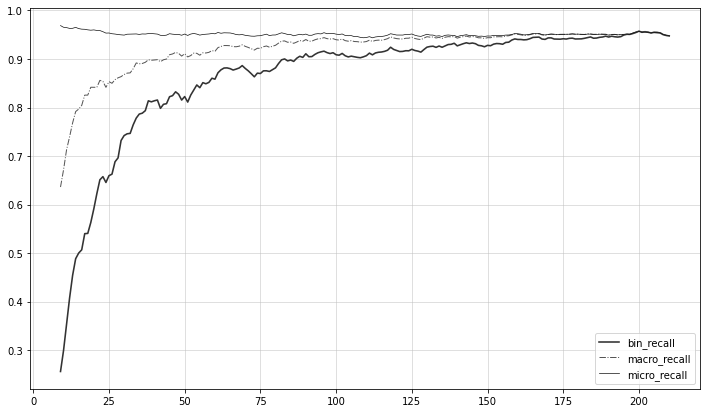

In [6]:
plt.figure(figsize = (12,7))
result.avg_bin_recall.rolling(10).mean().plot(color='#333333',
                                                   linestyle='-', linewidth=1.6)
result.avg_macro_recall.rolling(10).mean().plot(color='#555555',
                                                linestyle='-.', linewidth=1)
result.avg_micro_recall.rolling(10).mean().plot(color='#111111',
                                                     linestyle='-', linewidth=0.7)
plt.legend(['bin_recall','macro_recall', 'micro_recall'], loc=4)
plt.grid(color='#c1c1c1', linestyle='-', linewidth=0.5)
plt.show()

In [7]:
print('First range:\n', linregress(result.index[2:45], 
                                 result.avg_bin_recall[2:45]).slope)
print('Second range:\n', linregress(result.index[45:140], 
                                 result.avg_bin_recall[45:140]).slope)
print('Third range:\n', linregress(result.index[140:],
                                 result.avg_bin_recall[140:]).slope)

First range:
 0.013636974874516398
Second range:
 0.0008574255142085559
Third range:
 0.000357039103526396
